# Project_18 - Pytorch Classification (Blobs)

## Project Description
1. Create blob dataset using make_blobs package in sklearn
2. Train a torch.nn model to classify the blobs
3. Visualize the classification result

In [1]:
# import necessary packages
import torch
from torch import nn, optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
#import torchmetrics

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# create dataset using the make_blobs
n_samples = 1000
n_features = 2
random_state = 42
n_class = 4

X, y = make_blobs(n_samples, n_features, centers = n_class, cluster_std=1.5, random_state=random_state)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [4]:
print(X[:5], y[:5])
print(X.shape, y.shape)
print(X.dtype, y.dtype)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])
torch.Size([1000, 2]) torch.Size([1000])
torch.float32 torch.int64


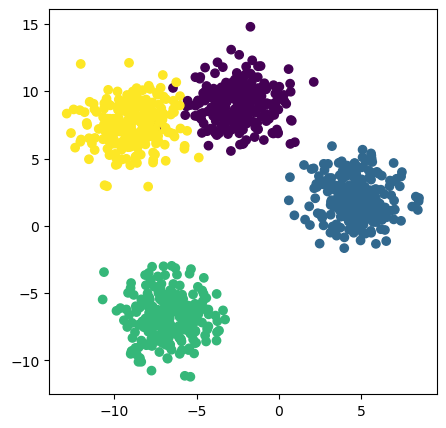

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [7]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test =y_train.to(device), y_test.to(device)

In [8]:
print(X_train.device, X_test.device, y_train.device, y_test.device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

cpu cpu cpu cpu
torch.float32 torch.float32 torch.int64 torch.int64


In [9]:
# create NN model
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 4),
    #nn.Softmax(dim=1)
).to(device)

model

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=4, bias=True)
)

In [10]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# check if the model performs correctly
print(model(X_train))

tensor([[-0.5509,  0.7678,  0.2074,  0.2812],
        [-0.3301,  1.1623,  0.3499,  0.5587],
        [-0.3250,  0.8761,  0.1027,  0.1569],
        ...,
        [-0.4272,  1.1828,  0.3390,  0.6077],
        [-0.2810,  0.7835,  0.0922,  0.0969],
        [-0.1784,  1.0628,  0.4796,  0.3889]], grad_fn=<AddmmBackward0>)


In [12]:
print(torch.argmax(model(X_train)[:50], dim=1))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [13]:
print(y_train[:50])

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
        3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
        1, 0])


In [14]:
# define accuracy function
def accuracy(y_pred, y_test):
  correct = torch.eq(y_pred, y_test).sum().item()
  accuracy = correct / len(y_pred)
  return accuracy

In [15]:
# train the NN model
epochs = 200
epoch_count = []
train_losses = []
test_losses = []

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  train_loss = loss_fn(y_logits, y_train)
  train_accuracy = accuracy_score(y_pred.cpu(), y_train.cpu())

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_score(test_pred.cpu(), y_test.cpu())

    epoch_count.append(epoch)
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss.cpu().detach().numpy())

  if epoch % 20 == 0:
    print(f'Epoch: {epoch} | Train_loss: {train_loss:.3} | Train_acc: {train_accuracy:.3} | Test_loss: {test_loss:.3} | Test_acc: {test_accuracy:.3}')

Epoch: 0 | Train_loss: 1.56 | Train_acc: 0.261 | Test_loss: 1.56 | Test_acc: 0.205
Epoch: 20 | Train_loss: 1.17 | Train_acc: 0.448 | Test_loss: 1.18 | Test_acc: 0.43
Epoch: 40 | Train_loss: 0.88 | Train_acc: 0.823 | Test_loss: 0.872 | Test_acc: 0.89
Epoch: 60 | Train_loss: 0.594 | Train_acc: 0.991 | Test_loss: 0.565 | Test_acc: 0.99
Epoch: 80 | Train_loss: 0.375 | Train_acc: 0.993 | Test_loss: 0.343 | Test_acc: 0.99
Epoch: 100 | Train_loss: 0.236 | Train_acc: 0.993 | Test_loss: 0.209 | Test_acc: 0.995
Epoch: 120 | Train_loss: 0.149 | Train_acc: 0.993 | Test_loss: 0.131 | Test_acc: 0.995
Epoch: 140 | Train_loss: 0.0992 | Train_acc: 0.993 | Test_loss: 0.0852 | Test_acc: 0.995
Epoch: 160 | Train_loss: 0.0719 | Train_acc: 0.991 | Test_loss: 0.0601 | Test_acc: 0.995
Epoch: 180 | Train_loss: 0.0566 | Train_acc: 0.993 | Test_loss: 0.0459 | Test_acc: 0.995


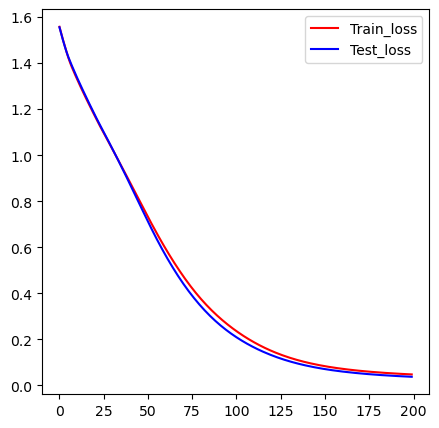

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_count, train_losses, c='r', label='Train_loss')
plt.plot(epoch_count, test_losses, c='b', label='Test_loss')
plt.legend()
plt.show()

In [17]:
# acc = torchmetrics.Accuracy(task="multiclass", num_classes=n_class)
# print(acc(y_pred, y_train))
# print(acc(test_pred, y_test))

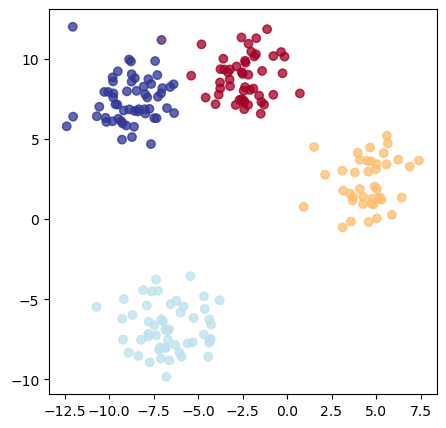

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=test_pred.cpu(), alpha=0.5, cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), alpha=0.5, cmap=plt.cm.RdYlBu)
plt.show()